# Extra final project
# - improving emissions estimations of the ClimateTrace electricity-generation sector

I was working on my final project mainly analyzing the 2021-2022 trends of power emissions, with modifying some errors before getting some guidance. After getting some more examples, I wanted to try again to look through the climatetrace dataset, whether there are any fundamental gaps or errors in the process of estimating emissions. This extra one is just for my self-satisfaction and academic curiosity, and I just submitted it for reference, thank you!

- Student ID: 3040688758
- Name: Seoyeon Kang

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas

## Introduction
- As mentioned in my other project, the population mean of the decrease value of co2 emissions from 2021 and 2022 by country wasn't significantly different from 0 (of the electricity-generation subsector). We should go over some assumptions the ClimateTrace data had while estimating emissions, since this rejection of the null may be due to systematic errors over the data.
- In this project, I checked the emissionsfactor difference of 2021 and 2022 over the world, and found some systematic, structural errors that a lot of countries, including most of the countries in Africa didn't have a change in the emissionsfactor of all of their plants.
- However, it is a known fact that the efficiency of power plants decrease as time passes, and this leads to an increase in emissionsfactor. The methodology document of ClimateTrace also mentions this, but it doesn't seem to be reflected on some countries. By resolving the systematic errors of emissionsfactor of the electricity-generation sector dataset, we can expect to gain more precise estimations of emissions.
- This project seeks to resolve those errors by reflecting the depreciation rate of the power plants over time, also considering the age of the given power plant - using LLMs to obtain the year that the operation started, and calculating the emissionsfactor of 2022.

## importing data

(The process I generated the importing function is in my original final project)
- We can make a function that imports data from the climatetrace api, by inputting sectors or subsectors.
- I imported the power sector data using this function.

In [ ]:
def read_climatetrace(sectors=False,subsectors=False,url="https://api.c10e.org/v4/assets"):
  '''
  Reads data from the Climate TRACE API.

  Args:
    sectors: A string or list of strings representing the sectors to query.
    subsectors: A string or list of strings representing the subsectors to query.
    url: The URL of the Climate TRACE API.

  Returns:
    A pandas DataFrame containing the requested data.
  '''

  if sectors and subsectors:
    p={'limit':100000,'sectors':sectors,'subsectors':subsectors}
  elif sectors:
    p={'limit':100000,'sectors':sectors}
  else:
    p={'limit':100000,'subsectors':subsectors}

  response = requests.get(url,params=p)
  data=response.json()
  if 'assets' in data:
    global resp
    resp=data['assets']

    df=pd.DataFrame(resp)

    df_exploded = df.explode('Emissions')
    df_normalized = pd.json_normalize(df_exploded['Emissions'])
    df_result = pd.concat([df_exploded.reset_index(drop=True), df_normalized], axis=1)
    df_result = df_result.drop('Emissions', axis=1)

    df_2021 = df_result.explode('2021')
    df_2022 = df_result.explode('2022')

    df_2021_extracted = pd.json_normalize(df_2021['2021'])
    df_2021 = pd.concat([df_2021.reset_index(drop=True), df_2021_extracted], axis=1)
    df_2022_extracted = pd.json_normalize(df_2022['2022'])
    df_2022 = pd.concat([df_2022.reset_index(drop=True), df_2022_extracted], axis=1)

    df_2021['gas'] = df_2021['2021'].apply(lambda x: list(x.keys())[-1] if isinstance(x, dict) else None)
    df_2022['gas'] = df_2022['2022'].apply(lambda x: list(x.keys())[-1] if isinstance(x, dict) else None)

    df_2021 = df_2021.drop('2021', axis=1)
    df_2022 = df_2022.drop('2022', axis=1)

    df_2021['year']=2021
    df_2022['year']=2022
    df_final=pd.concat([df_2021,df_2022])

    df_final['lat'] = df_final['Centroid'].apply(lambda x: x.get('Geometry', [None, None])[1])
    df_final['lon'] = df_final['Centroid'].apply(lambda x: x.get('Geometry', [None, None])[0])

    df_final = df_final.drop(['ReportingEntity','NativeId','Centroid','Owners','Confidence','Thumbnail','2021','2022'], axis=1)
    df_final = df_final.dropna(subset=['gas'])

    return df_final

In [ ]:
power=read_climatetrace(sectors='Power')

## Data cleaning process

- As I found in my final project, there were unmatching IDs between 2021 and 2022 data, even though the other information of the observations was matching each other. I used the function I made to modify these unmatching IDs.
- Moreover, let;s clean the data by dropping the other columns of gas other than co2 and observations with nan values of co2. Let's also analyze with power plants operating, by filtering out observations that do not have activity.

In [ ]:
def modify_ids(df):
  """
  Modifies mismatched IDs in the dataframe.

  Args:
    df: The dataframe that needs modification

  Returns:
    The modified dataframe with corrected IDs.
  """
  df_2021=df[df['year']==2021]
  df_2022=df[df['year']==2022]

  df_2021_unique=df_2021.drop_duplicates(subset=['Name'])

  for i in range(len(df_2021_unique)):
    name=df_2021_unique['Name'].values[i]
    id_2021=df_2021_unique[df_2021_unique['Name']==name]['Id'].values[0]
    try:
      id_2022 = df_2022[df_2022['Name']==name]['Id'].values[0]
      if id_2021!=id_2022:
        df_2021.loc[df_2021['Id']==id_2021,'Id']=id_2022
    except:
      continue
  df=pd.concat([df_2021,df_2022],ignore_index=True)
  return df

In [ ]:
power=power[power['gas']=='co2'].drop(columns=['n2o','ch4','co2e_20yr','co2e_100yr'])
power=power[power['Activity']>0]
power=modify_ids(power)

In [ ]:
power

,Id,Name,Country,Sector,AssetType,Activity,ActivityUnits,Capacity,CapacityFactor,CapacityUnits,EmissionsFactor,EmissionsFactorUnits,co2,gas,year,lat,lon
0,25452242,Taichung power station,TWN,electricity-generation,"coal, oil",36702000.0,MWh,5834.0,0.718,MW,0.916,T of CO2 per MWh,33602000.0,co2,2021,24.2150,120.4790
1,25451253,Taean power station,KOR,electricity-generation,"coal, other_fossil",34160000.0,MWh,6480.0,0.602,MW,0.989,T of CO2 per MWh,33774000.0,co2,2021,36.9033,126.2343
2,25452360,Surgut GRES-2 power station,RUS,electricity-generation,gas,34920000.0,MWh,8898.0,0.448,MW,0.885,T of CO2 per MWh,30900000.0,co2,2021,61.2794,73.4889
3,25451254,Dangjin power station,KOR,electricity-generation,coal,32752000.0,MWh,6040.0,0.619,MW,0.989,T of CO2 per MWh,32380000.0,co2,2021,37.0551,126.5122
4,25451405,Togtoh power station,CHN,electricity-generation,coal,31904000.0,MWh,6720.0,0.542,MW,0.897,T of CO2 per MWh,28631000.0,co2,2021,40.1952,111.3589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15259,25450205,Amata,VNM,electricity-generation,oil,1000.0,MWh,13.0,0.009,MW,1.000,T of CO2 per MWh,1000.0,co2,2022,10.9471,106.9000
15260,25451045,Osijek power station,HRV,electricity-generation,oil,2000.0,MWh,115.0,0.002,MW,0.500,T of CO2 per MWh,1000.0,co2,2022,45.5420,18.7449
15261,25457039,"Biomass to Energy Facility, Kauai",USA,electricity-generation,"biomass, oil",1000.0,MWh,1.0,0.114,MW,1.000,T of CO2 per MWh,1000.0,co2,2022,21.9653,-159.4606
15262,25453305,Dandeli Mill,IND,electricity-generation,"biomass, oil",1000.0,MWh,7.0,0.016,MW,1.000,T of CO2 per MWh,1000.0,co2,2022,15.2530,74.6297


- To compare 2021 and 2022 differences of the emissions or emissionfactors, we can separate the dataset into two datasets by year, **power_2021** and **power_2022**, then merge them on 'Id' values.
- Since the new merged dataframe has too much columns, I dropped some columns that are not needed and changed the names of the remaining columns to clarify them.

In [ ]:
power_2021=power[power['year']==2021]
power_2022=power[power['year']==2022]

In [ ]:
power_df=pd.merge(power_2021,power_2022,on='Id')

In [ ]:
power_df.columns

Index(['Id', 'Name_x', 'Country_x', 'Sector_x', 'AssetType_x', 'Activity_x',
       'ActivityUnits_x', 'Capacity_x', 'CapacityFactor_x', 'CapacityUnits_x',
       'EmissionsFactor_x', 'EmissionsFactorUnits_x', 'co2_x', 'gas_x',
       'year_x', 'lat_x', 'lon_x', 'Name_y', 'Country_y', 'Sector_y',
       'AssetType_y', 'Activity_y', 'ActivityUnits_y', 'Capacity_y',
       'CapacityFactor_y', 'CapacityUnits_y', 'EmissionsFactor_y',
       'EmissionsFactorUnits_y', 'co2_y', 'gas_y', 'year_y', 'lat_y', 'lon_y'],
      dtype='object')

In [ ]:
power_df=power_df.drop(columns=['ActivityUnits_x','CapacityUnits_x','EmissionsFactorUnits_x','gas_x','year_x',
                       'Name_y','Country_y','Sector_y','AssetType_y','ActivityUnits_y','CapacityUnits_y','EmissionsFactorUnits_y','gas_y','year_y','lat_y','lon_y'])
power_df.columns=['Id','Name','Country','Sector','AssetType','Activity_2021','Capacity_2021','CapacityFactor_2021','EmissionsFactor_2021','co2_2021','lat','lon',
                  'Activity_2022','Capacity_2022','CapacityFactor_2022','EmissionsFactor_2022','co2_2022']

In [ ]:
power_df

,Id,Name,Country,Sector,AssetType,Activity_2021,Capacity_2021,CapacityFactor_2021,EmissionsFactor_2021,co2_2021,lat,lon,Activity_2022,Capacity_2022,CapacityFactor_2022,EmissionsFactor_2022,co2_2022
0,25452242,Taichung power station,TWN,electricity-generation,"coal, oil",36702000.0,5834.0,0.718,0.916,33602000.0,24.2150,120.4790,35712000.0,5834.0,0.699,0.916,32698000.0
1,25451253,Taean power station,KOR,electricity-generation,"coal, other_fossil",34160000.0,6480.0,0.602,0.989,33774000.0,36.9033,126.2343,32607000.0,6480.0,0.574,0.989,32237000.0
2,25452360,Surgut GRES-2 power station,RUS,electricity-generation,gas,34920000.0,8898.0,0.448,0.885,30900000.0,61.2794,73.4889,35622000.0,8898.0,0.457,0.885,31521000.0
3,25451254,Dangjin power station,KOR,electricity-generation,coal,32752000.0,6040.0,0.619,0.989,32380000.0,37.0551,126.5122,31270000.0,6040.0,0.591,0.989,30915000.0
4,25451405,Togtoh power station,CHN,electricity-generation,coal,31904000.0,6720.0,0.542,0.897,28631000.0,40.1952,111.3589,31175000.0,6720.0,0.530,0.897,27976000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7532,25449005,Scherer,USA,electricity-generation,"coal, gas",12017000.0,3564.0,0.385,0.841,10108000.0,33.0606,-83.8075,8873000.0,2673.0,0.379,0.934,8284000.0
7533,25448963,River Rouge,USA,electricity-generation,"coal, oil",1412000.0,369.0,0.437,0.931,1315000.0,42.2739,-83.1119,15000.0,11.0,0.156,0.667,10000.0
7534,25448904,Mystic Generating Station,USA,electricity-generation,"gas, oil",5703000.0,2376.0,0.274,0.369,2105000.0,42.3908,-71.0675,5272000.0,1744.0,0.345,0.321,1692000.0
7535,25448874,H.R. Milner power station,CAN,electricity-generation,coal,1066000.0,150.0,0.811,0.939,1001000.0,54.0077,-119.1036,1964000.0,354.0,0.633,0.829,1628000.0


## Analyzing EmissionsFactor column

- From now on, let's analyze the 'EmissionsFactor' column in earnest. EmissionsFactor is a significant part of estimating emissions, since it is a major component of the estimated emissions. The emissions are estimated by multiplying the estimated generation of each plant by an emissions factor, according to the climatetrace methodology (https://github.com/climatetracecoalition/methodology-documents/blob/main/2023/Power/Power%20sector-%20Emissions%20from%20Electricity%20Generation%20Methodology.docx.pdf, p.20)
- We have to check whether there are no constructive errors in the emissionsfactor column.


---
- I checked whether the estimated co2 emission quantities are really calculated by multiplying the activity and the emissionsfactor of each powerplant with the 2022 data. We can see that there are slight differences, but insignificant. (Maybe there is some other method to arrange the final values of emissions at the end.)




---
- We can make a new column of 'emfactor_diff', which is the difference between the emissionsfactor of 2022 and 2021.
- If we see at the summary statistics if 'emfactor_diff', the value is not uniformly distributed at 0, but is highly centered at 0. With the Q1 value as 0 and Q3 value 0.001(close to 0), over 50% of the observations have no changes in the emissions factor.
- The histogram of emfactor_diff also shows the highly centered distribution of the observations, with almost 6,000 observations having a value proximate to 0.
- This may not make sense in the real world, and we have to seek if there are any structural, constructive errors in the emissionsfactor, to improve the estimated emissions.


In [ ]:
power_df['co2_2022_test']=power_df['Activity_2022']*power_df['EmissionsFactor_2022']
power_df[['co2_2022','co2_2022_test']]

,co2_2022,co2_2022_test
0,32698000.0,32712192.0
1,32237000.0,32248323.0
2,31521000.0,31525470.0
3,30915000.0,30926030.0
4,27976000.0,27963975.0
...,...,...
7532,8284000.0,8287382.0
7533,10000.0,10005.0
7534,1692000.0,1692312.0
7535,1628000.0,1628156.0


In [ ]:
power_df['emfactor_diff']=power_df['EmissionsFactor_2022']-power_df['EmissionsFactor_2021']

In [ ]:
power_df.emfactor_diff.describe()

,emfactor_diff
count,7537.000000
mean,0.000183
std,0.020258
min,-0.525000
25%,0.000000
50%,0.000000
75%,0.001000
max,0.387000


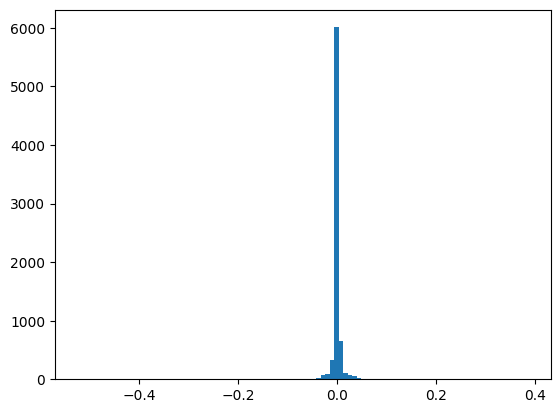

In [ ]:
plt.hist(power_df.emfactor_diff,bins=100)
plt.show()

- We can look at the emissionsfactor difference by country, to confirm whether there are systematic errors by country.
- I summed the emfactor_diff column by country, and made a new filtered dataframe **emfactor_diff** with countries that have emfactor_diff values exactly matching 0.
- There are 83 countries that doesn't have changes in all of the emissionsfactor of their powerplants, which may not be convincing.

In [ ]:
emfactor_diff=power_df[['Country','emfactor_diff']].groupby('Country').sum().reset_index()
emfactor_diff_0=emfactor_diff[emfactor_diff['emfactor_diff']==0]
emfactor_diff_0

,Country,emfactor_diff
0,ABW,0.0
1,AGO,0.0
4,ARM,0.0
7,AZE,0.0
9,BEN,0.0
...,...,...
151,TZA,0.0
152,UGA,0.0
157,VEN,0.0
159,XKX,0.0


In [ ]:
len(emfactor_diff_0)

83

- To check whether these countries with no emissionsfactor change have a certain pattern or commonality, I plotted a world map with the countries included in this dataframe colored.
- We can do this by merging the emfactor_diff_0 dataframe with the world(from geopandas library) on countries. Then plot the map by the 'emfactor_diff' column, so that countries that do not have nan values for the column are colored.

In [ ]:
world=geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

emfactor_diff_0=world.merge(emfactor_diff_0,left_on='iso_a3',right_on='Country')

<ipython-input-20-945c61171114>:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world=geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


<ipython-input-21-2275955f4ddb>:5: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  emfactor_diff_0.plot(ax=ax,column='emfactor_diff',color='grey')


<Axes: >

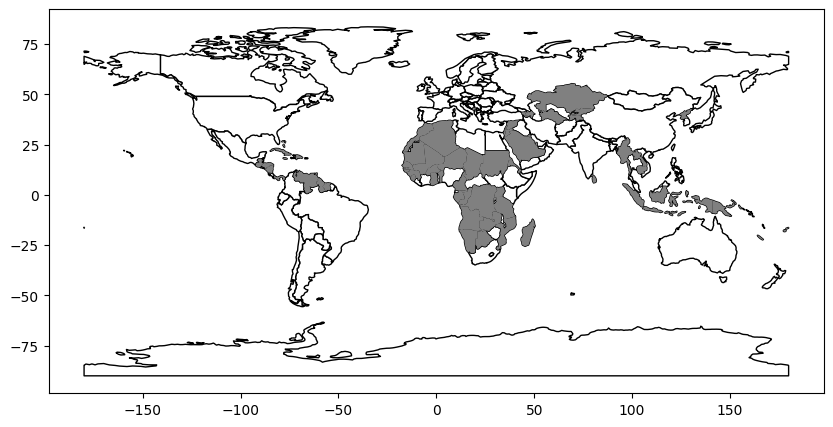

In [ ]:
fig,ax=plt.subplots(figsize=(10,6))

world.plot(ax=ax,color='white',edgecolor='black')

emfactor_diff_0.plot(ax=ax,column='emfactor_diff',color='grey')

- The countries that systematically didn't have changes in the emissionsfactor of their powerplants are mostly African countries. It is also noticeable that powerplants in Singapore also don't have a change in their emissionsfactor.
- If we look at the plot below, with all of the powerplants in climatetrace data plotted, even there are not that much powerplants in Africa, they do exist. Also, there are fairly many plants located in Singapore. These errors should be managed, since it is likely that they do not reflect facts in the real world

In [ ]:
power_gdf=geopandas.GeoDataFrame(power_2022,geometry=geopandas.points_from_xy(power_2022.lon,power_2022.lat))

<Axes: >

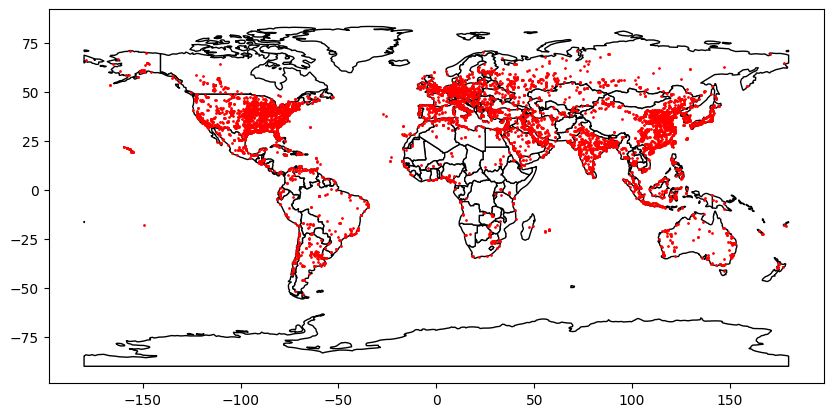

In [ ]:
fig,ax=plt.subplots(figsize=(10,6))

world.plot(ax=ax,color='white',edgecolor='black')

power_gdf.plot(ax=ax,markersize=1,color='red')

## Fixing errors of emissonsfactor

According to ClimateTrace power methodology, emissions factor is calculated by considering regional power plant efficiency (age, technology level, size), fuel quality, and the impact of ambient conditions(p.26).
- It is clear that there will be a depreciation in the efficiency of the power plant over time, which will lead to an increase in emissionsfactor, but the climatetrace data turned out that it doesn't reflect this for countries in Africa, or Singapore.
- By using some depreciation functions of powerplants and applying them on climatetrace data, we can better reflect the real world emissions to our estimated emissions.


---


- To reflect the depreciation of efficiency over time, I will apply the widely used power plant's depreciation rate formula to the emissions factor (by multiplying by the reciprocal)


- We can refer to https://www.bclaws.gov.bc.ca/civix/document/id/complete/statreg/53_2016 for the depreciation rate of power plants. The depreciation rate for power plant can be calculated by $depreciation rate = percentage rate * age$, where the power plant's percentage rate is 1.25%.
- Since the depreciation rate at age n is 1.25\*n %, the emissions factor will become em(1)\*[100/(100-1.25\*n)], where em(1) is the emissionsfactor of the first year of the power plant(multiplying by the reciprocal value, since the power plant value of year n = value(1)\*((100-1.25n)/100)). Accordingly, we can get the emissionsfactor of year (n+1) by the following formula: [(100-1.25(n))/(100-1.25(n+1))]*em(n), where em(n) is the emissionsfactor for the year of power plant age (n).







- Although it has the limitation of not reflecting the technological differences in each region, it is significant in that it can reflect the increase in emissions due to the depreciation of the age and efficiency of the factory to some extent.
- Using the formula, we can obtain the emissionsfactor of year 2022, reflecting the depreciation of the power plant based on its age.

---


- We can obtain the age of the power plant by asking LLMs.
- I will first try it on a single power plant located in Namibia, which is a country in Africa, with no change of emissionsfactor of its power plants.

In [ ]:
%%capture
!pip install openai

In [ ]:
from google.colab import userdata
from openai import OpenAI
import ast

OPENAI_API_KEY=userdata.get('openai_apikey')
client=OpenAI(api_key=OPENAI_API_KEY)

In [ ]:
power_df[power_df['Country']=='NAM']

,Id,Name,Country,Sector,AssetType,Activity_2021,Capacity_2021,CapacityFactor_2021,EmissionsFactor_2021,co2_2021,lat,lon,Activity_2022,Capacity_2022,CapacityFactor_2022,EmissionsFactor_2022,co2_2022,co2_2022_test,emfactor_diff
6324,25451443,Van Eck power station,NAM,electricity-generation,coal,50000.0,120.0,0.048,1.340,67000.0,-22.5116,17.0787,50000.0,120.0,0.048,1.340,67000.0,67000.0,0.0
7432,25451442,Paratus (Walvis),NAM,electricity-generation,oil,6000.0,33.0,0.021,1.167,7000.0,-22.9575,14.5053,6000.0,33.0,0.021,1.167,7000.0,7002.0,0.0
7444,25454714,Anixas,NAM,electricity-generation,oil,4000.0,23.0,0.020,1.250,5000.0,-22.9399,14.5164,4000.0,23.0,0.020,1.250,5000.0,5000.0,0.0
7462,25454339,Langer-Heinrich,NAM,electricity-generation,oil,2000.0,10.0,0.023,1.000,2000.0,-22.8138,15.3248,2000.0,10.0,0.023,1.000,2000.0,2000.0,0.0


In [ ]:
facility_name='Van Eck power station'
facility_country='NAM'
MODEL="gpt-4o"

In [ ]:
response=client.chat.completions.create(
    model=MODEL,
    messages=[
        {'role':'system',
         'content':'''
         You will  be asked to identify the start year of operation of an electricity-generation facility, like power station.
         If there are several units within the facility, please return the earliest year.

         Return the start year of the power plant, only the number.
         With only citations included additionally, provide a valid citation. Return this in a dictionary form.

         Here is an example of the expected dictionary form:

         {'Start year':2000,'citation':'https://www.google.com'}

         '''},
        {'role':'user',
         'content':f'''
         Find the information on the start year of operation for the {facility_name} powerplant, based in {facility_country}.
         '''}
    ]
)

In [ ]:
response.choices[0].message.content

"{'Start year': 1972, 'citation': 'https://en.wikipedia.org/wiki/Van_Eck_Power_Station'}"

- Using the response of the LLM, we can obtain the power plant's age. Then, we can use the 2021 emissionsfactor value and the decipriation rate described earlier(using the plant's age of 2021 and 2022) to get the emissionsfactor value for 2022.
- For the example, we can get the emissionsfactor of 2022, which is higher than is original value of 1.340. We can say this reflects the real world efficiency depriciation, leading to the increase in emissions.

In [ ]:
n=2021-ast.literal_eval(response.choices[0].message.content)['Start year']

emfac_2022=power_df[power_df['Name']==facility_name]['EmissionsFactor_2021'].values[0]*((100-1.25*(n))/(100-1.25*(n+1)))
emfac_2022

1.384666666666667

- Since we applied this in a single observation, we can proceed on to modify the other emissionsfactor that had an systematical error accross the country.
- We can generate a function called **get_startyear()**, as a middle stage of obtaining the plant's age.

In [ ]:
def get_startyear(facility_name,facility_country):
  '''
  Gets the start year of a power plant.

  Args:
    facility_name: The name of the power plant.
    facility_country: The country of the power plant.

  Returns:
    The start year of the power plant.
  '''

  MODEL="gpt-4o"
  response=client.chat.completions.create(
    model=MODEL,
    messages=[
        {'role':'system',
         'content':'''
         You will  be asked to identify the start year of operation of an electricity-generation facility, like power station.
         If there are several units within the facility, please return the earliest year.

         Return the start year of the power plant, only the number.
         With only citations included additionally, provide a valid citation. Return this in a dictionary form.

         Here is an example of the expected dictionary form:

         {'Start year':2000,'citation':'https://www.google.com'}

         '''},
        {'role':'user',
         'content':f'''
         Find the information on the start year of operation for the {facility_name} powerplant, based in {facility_country}.
         '''}
    ]
)
  return  ast.literal_eval(response.choices[0].message.content)

- Using the get_startyear() function, we can make a function called **correct_emfactor()**, which returns the modified emissionsfactor of 2022 of the facility name it takes.
- I checked whether it works well with another power plant in Namibia, and it does return a higher emissionsfactor compared to 2021, reflecting the depreciation rate (modified from 1.167 to 1.201).

In [ ]:
def correct_emfactor(facility_name):
  '''
  Gets the modified emissions factor of 2022 of a power plant.

  Args:
    facility_name: The name of the power plant.

  Returns:
    The corrected 2022 emissions factor of the power plant.
    '''

  facility_country=power_df[power_df['Name']==facility_name]['Country'].values[0]
  emfac_2021=power_df[power_df['Name']==facility_name]['EmissionsFactor_2021'].values[0]
  n=2021-get_startyear(facility_name,facility_country)['Start year']
  emfac_2022=emfac_2021*((100-1.25*(n))/(100-1.25*(n+1)))
  return emfac_2022

In [ ]:
correct_emfactor('Paratus (Walvis)')

1.2013235294117646

- Now, we can expand this to other countries, to resolve the systematic errors over ClimateTrace data.
- We can store the countries that have no change of emissionsfactor among their power plants, in **country_list**.
- Then, by looping through the observations in the power_df, and modify the 'EmissionsFactor_2022' value for observations that have its 'Country' value inside the country_list, we can fix the values of emissionsfactor of 2022 which were generated under assumptions that do not reflect reality.
- I didn't run the cell, and just left it as a comment, due to the limits of LLM usage.

In [ ]:
country_list=emfactor_diff_0['Country'].values

In [ ]:
#for i in range(len(power_df)):
  #if power_df['Country'].values[i] in country_list:
    #power_df['EmissionsFactor_2022'].values[i]=correct_emfactor(power_df['Name'].values[i])

- By resolving the systematic errors in the emissionsfactor of 2022, we can recalculate the estimations of co2 emissions. With the modification of emission quantities in 2022, we may now have different conclusions for whether the population mean of decrease value in co2 emissions from 2021 to 2022 by country is significantly different from 0. This will lead to an enhancement of the emissions estimation of individual plants, since it is reflecting the fact that power plants have depreciation in their efficiency as time passes.

## Conclusion

- For the electricity-generation subsector, the ClimateTrace estimates the emissions of individual plants by multiplying the estimated generation of each plant by an emissions factor. Thus, the emissionsfactor is a significant part or estimating emissions.
- Comparing the sum of co2 emissions of 2021 and 2022 by country, the population mean of the emissions decrease value of countries turned out to be statistically not different with zero. We have to check whether these statistical conclusions are acceptable and that there are no underlying errors in the assumptions of the data. This project takes a closer look at the emissionsfactor in the ClimateTrace data to check for errors in assumptions.
- It turned out that analyzing the change in emissionsfactors from 2021 to 2022 by country, in about half of the countries there was no change in emissionsfactors at all for all power plants, with a clear systematic error of no change in most countries in Africa. Since it is a known fact that power plants become less efficient and emit more over time, these errors show that the assumptions of ClimateTrace data do not accurately reflect the real world.
- To address this error, this project utilized the power plant's depreciation rate and corrected the 2022 emissionsfactor for the increase in emissions to account for the plant's age. The age of the plant was calculated by obtaining the plant's start-up year from LLM, and the depreciation rate of the power plant was set by referring to British Columbia's Assessment Act.

- This project has a limit that it did not reflect the efficiency differences due to regional technology differences, and did not use an accurate formulation of the power plant emissionsfactor over time. However, it is significant that we found an error in the assumption in the process of calculating the estimated emissions from the ClimateTrace data, and the emissions factor was modified to better reflect reality by using the depreciation rate that takes into account the age of the powerplant.